## Using Ignis together with Python Jupyter notebooks

 To begin, you will need to have Ignis installed on your system. Have a look at [Setup](../setup.rst) to learn how to build Ignis on your machine.
 
 Depending on how you installed Ignis, the following process for importing the API may differ. 
 In this tutorial, we will directly use the path to the underlying API library and load it directly with the following code.

In [ ]:
def load_api():
    """ Load the api and return a module object """

    import sys
    import importlib
    from pathlib import Path

    #####################################################################################################################
    ig_dir = Path("C:\\Development\\Projects\\Ignis\\build\\Release\\api\\ignis") # <----------- Adapt this to your need.
    #####################################################################################################################
    # The directory has to contain a shared library 'pyignis*'.
    # The actual name of the shared library depends on your Python version and operating system.

    if not ig_dir.exists():
        raise RuntimeError(
            "The given directory does not exist! Maybe the Python API is not enabled via cmake?")

    spec = importlib.util.spec_from_file_location(
        "ignis", ig_dir.joinpath("__init__.py"))
    module = importlib.util.module_from_spec(spec)
    sys.modules[spec.name] = module
    spec.loader.exec_module(module)

    return module

ignis = load_api()

The Ignis API should now be available via the module name `ignis`. You can check if it is working by querying the version:

In [10]:
ignis.__version__

'0.3.5'

To proceed, lets build a scene directly inside Python. The scene will consist of two spheres and a plane serving as a floor. The illumination of the scene will be achieved by a point light source positioned at the center. The camera will be set to look down from outside the scene towards the center.

In [11]:
def create_scene():
    """Will describe a scene directly in Python"""

    # A scene can be defined directly within Python, as it is just a simple json file
    scene_desc = {
        "technique": {
            "type": "path",
            "max_depth": 32
        },
        "camera": {
            "type": "perspective",
            "fov": 90,
            "near_clip": 0.01,
            "far_clip": 100,
            "transform": [{"lookat": { "origin": [-1,-2,2], "up": [0,0,1], "target": [0,0,0]}}]
        },
        "film": {
            "size": [1024, 1024]
        },
        "bsdfs": [
            {"type": "diffuse", "name": "ground", "reflectance": 0.95},
            {"type": "diffuse", "name": "sphere_left", "reflectance": [0, 0, 1]},
            {"type": "diffuse", "name": "sphere_right", "reflectance": [0, 1, 0]}
        ],
        "shapes": [
            {"type": "sphere", "name": "Sphere", "radius": 1},
            {"type": "rectangle", "name": "Bottom", "width": 10, "height": 10}
        ],
        "entities": [
            {"name": "Bottom", "shape": "Bottom", "bsdf": "ground", "transform": [{"translate": [0,0,-2]}]},
            {"name": "SphereLeft", "shape": "Sphere", "bsdf": "sphere_left", "transform": [{"translate": [1,0,0]}]},
            {"name": "SphereRight", "shape": "Sphere", "bsdf": "sphere_right", "transform": [{"translate": [-1,1,0]}]}
        ],
        "lights": [
            {"name": "PointLight", "type": "point", "position": [0,0,3], "intensity": [100, 100, 100]}
        ]
    }

    # Ignis requires a string, so we convert the dictionary description to a json string
    import json

    # Load the scene
    return ignis.Scene.loadFromString(json.dumps(scene_desc))

We could introduce parameters into our scene and dynamically adjust it each time we invoke the `create_scene()` function. However, for the purposes of simplicity, let us continue with the rendering of the scene and keep the scene as it is.

In [12]:
# We require numpy (or any library support the buffer interface of Python) to work with the final output
import numpy as np

# This function will render a scene until the target samples per pixel is reached and return the correct normalized image back to the callee. 
def render(scene, spp):
    with ignis.loadFromScene(scene) as runtime:
        while runtime.SampleCount < spp:
            runtime.step()
        color = np.asarray(runtime.getFramebufferForHost()) / runtime.IterationCount
        return color

Although we have not yet generated a rendered image, we have successfully created a function capable of rendering any scene with a specified number of samples. It is important to note that a higher number of samples leads to an improvement in image quality, but at the cost of longer render times. Further, as batch rendering is enabled by default, the final spp might be greater than the requested spp.

With this in mind, let us proceed with the rendering process without any delay.

In [13]:
scene = create_scene() # Our previously defined scene
output = render(scene, 64) # We render the scene for at least 64 spp

[Info   ] Using target GPU[Nvidia,D=0]
[Info   ] Using device NVIDIA GeForce RTX 3080


The rendering process has been completed; however, the final step involves displaying the resulting image here in Jupyter. This can be achieved by utilizing any preferred plotting library and invoking a function to display the image. We use `matplotlib` for display.

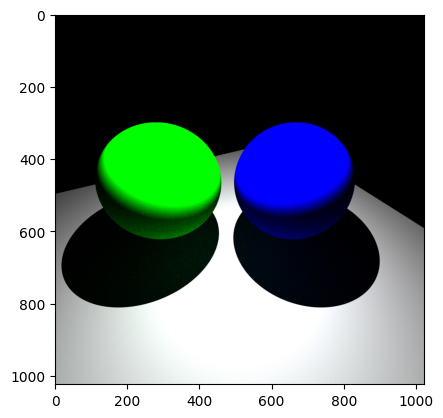

In [14]:
from matplotlib import pyplot as plt
plt.imshow(np.clip(output, 0, 1))
plt.show()

The rendered image is now displayed. You should be able to see two sphere with two different colors and a gray floor.

This is all required to render an image.
However, we have the option of enhancing the final image by applying tonemapping to it. The image produced by the rendering process is in High Dynamic Range (HDR) format and is not bounded between the usual range of [0, 1]. As most display devices are not equipped to handle such a high range, we must implement tonemapping to enable the image to be displayed on standard monitors and, for example, the internet. In order to achieve this, we will apply a simple `reinhard` tonemapping algorithm.

In [15]:
# The following function computes the luminance of sRGB colors
def luminance(image):
    r = image[:, :, 0]
    g = image[:, :, 1]
    b = image[:, :, 2]
    return 0.2126 * r + 0.7152 * g + 0.0722 * b


# Following is the very simple reinhard tonemapping operator
def reinhard(image):
    L = np.percentile(luminance(image), 95)  # Based on the highest luminance
    WhitePoint = 4  # A user parameter. It is fixed to 4 for now
    factor = L * (1 + L / (WhitePoint * WhitePoint)) / (1 + L)
    return image * factor


# The rendered image in giving in linear space. We have to apply gamma correction
def gamma(image):
    return np.clip(np.power(image, 1/2.2), 0, 1)

Using the newly created tonemapping function the image looks perceptually better.

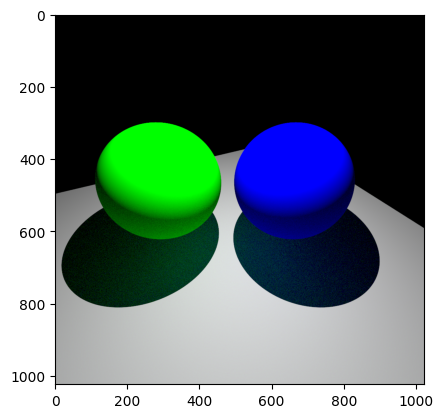

In [16]:
plt.imshow(gamma(reinhard(output)))
plt.show()

This concludes the tutorial. There are more ways to render images and acquire information from the scene. For example, the API is capable of tracing single rays and change underlying properties via the predefined parameters. More on these topics in the future.